In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
fileList = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        fileList.append(filename)
        print(os.path.join(dirname, filename))
print(fileList)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/classifying-contest/submission_file.csv
/kaggle/input/classifying-contest/data.csv
/kaggle/input/full-sentence-dataset/preprocessedData.csv
/kaggle/input/full-sentence-dataset/submitInput.csv
/kaggle/input/preprocessed-data/preprocessedData.csv
/kaggle/input/preprocessed-data/submitInput.csv
/kaggle/input/preprocessed-data/solution.csv
/kaggle/input/preprocessed-data/__results___files/__results___36_1.png
/kaggle/input/code-table/code.csv
/kaggle/input/encodeddata/encodedData.txt
/kaggle/input/encodeddata/encoded_model_data.txt
./__notebook__.ipynb
['__notebook__.ipynb']


In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 454 kB/s            
     |████████████████████████████████| 448 kB 51.9 MB/s            


In [3]:
import numpy as np
import pandas as pd
from konlpy.tag import Okt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Important Hyperparameter**

In [4]:
BATCH_SIZE = 200
EPOCH_A = 40
EPOCH_B = 50
STEP = 700
how_to_split = 800000

VECTOR_SIZE = 1300

In [5]:
raw_data = pd.read_csv("../input/encodeddata/encodedData.txt", sep='|')
raw_model_data = pd.read_csv("../input/encodeddata/encoded_model_data.txt", sep='|')

In [6]:
def code_table():
    code_table = pd.read_csv("../input/code-table/code.csv", sep=',')
    code_table = code_table[code_table['member'].notnull()]
    code_table = code_table.reset_index(drop=True)
    code_table = code_table.fillna(method='pad')
    code_table['member'] = code_table['member'].astype(int)
    return code_table

def preprocessInput(data):
    tem_input = []
    for i in range(len(data['sentence'])):
        if (i%100) == 0:
            print('.', end = ' ')
        if (i%5000) == 0:
            print(i, '\n', end = ' ')
        tokenized_sentence = okt.morphs(str(data['sentence'][i]), stem=True)
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
        joined_word = ' '.join(stopwords_removed_sentence)
        tem_input.append(joined_word)
    return tem_input

# LOOK AHEAD THE DATA

In [7]:
stopwords = ['갖추다','에서','의','가','을','이','은','들','는','좀','잘','일반','과','도','를','으로','자','에','와','한','하다','에게','일반','및','등','로']
okt = Okt()

In [8]:
raw_model_data = raw_model_data.fillna(' ')
raw_model_data['sentence'] = raw_model_data['text_obj'] +' '+raw_model_data['text_mthd'] +' '+ raw_model_data['text_deal']
raw_model_data

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,sentence
0,id_000001,,,,치킨전문점에서,고객의주문에의해,치킨판매,치킨전문점에서 고객의주문에의해 치킨판매
1,id_000002,,,,산업공구,다른 소매업자에게,철물 수공구,산업공구 다른 소매업자에게 철물 수공구
2,id_000003,,,,절에서,신도을 대상으로,불교단체운영,절에서 신도을 대상으로 불교단체운영
3,id_000004,,,,영업장에서,고객요구로,자동차튜닝,영업장에서 고객요구로 자동차튜닝
4,id_000005,,,,실내포장마차에서,접객시설을 갖추고,"소주,맥주제공","실내포장마차에서 접객시설을 갖추고 소주,맥주제공"
...,...,...,...,...,...,...,...,...
99995,id_099996,,,,사업장에서,일반인대상으로,버섯농장,사업장에서 일반인대상으로 버섯농장
99996,id_099997,,,,한의원에서,외래환자위주고,치료,한의원에서 외래환자위주고 치료
99997,id_099998,,,,일반점포에서,소비자에게,그림판매,일반점포에서 소비자에게 그림판매
99998,id_099999,,,,사업장에서,일반인.학생대상으로,학습공간제공,사업장에서 일반인.학생대상으로 학습공간제공


In [9]:
raw_data['sentence'] = raw_data['text_obj'] +' '+raw_data['text_mthd'] +' '+ raw_data['text_deal']
raw_data = raw_data.dropna()
raw_data = raw_data.reset_index();

In [10]:
raw_data.insert(5, "digit_4",raw_data['digit_3'].apply(lambda x:str(x)[-1:]),True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925009 entries, 0 to 925008
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   index      925009 non-null  int64 
 1   AI_id      925009 non-null  object
 2   digit_1    925009 non-null  object
 3   digit_2    925009 non-null  int64 
 4   digit_3    925009 non-null  int64 
 5   digit_4    925009 non-null  object
 6   text_obj   925009 non-null  object
 7   text_mthd  925009 non-null  object
 8   text_deal  925009 non-null  object
 9   sentence   925009 non-null  object
dtypes: int64(3), object(7)
memory usage: 70.6+ MB


# PREPROCESSING

In [11]:
def translate_to_id(target, id_dic):
    target = target.map(id_dic.get).dropna()
    return target

In [12]:
digit2_unique = raw_data['digit_2'].unique()
digit_2_id = {v:k for k,v in enumerate(digit2_unique)} #73

digit4_unique = raw_data['digit_4'].unique()
digit_4_id = {v:k for k,v in enumerate(digit4_unique)} #10

In [13]:
temp = raw_data['digit_4'].map(digit_4_id.get).dropna()
if len(temp) == len(raw_data):
    print('no-null')
    raw_data['digit_4'] = temp
    
temp = raw_data['digit_2'].map(digit_2_id.get).dropna()
if len(temp) == len(raw_data):
    print('no-null')
    raw_data['digit_2'] = temp
    
raw_data

no-null
no-null


,index,AI_id,digit_1,digit_2,digit_3,digit_4,text_obj,text_mthd,text_deal,sentence
0,0,id_0000001,S,0,952,0,카센터에서,자동차부분정비,타이어오일교환,카센터에서 자동차부분정비 타이어오일교환
1,1,id_0000002,G,1,472,0,상점내에서,일반인을 대상으로,채소.과일판매,상점내에서 일반인을 대상으로 채소.과일판매
2,2,id_0000003,G,2,467,1,절단하여사업체에도매,공업용고무를가지고,합성고무도매,절단하여사업체에도매 공업용고무를가지고 합성고무도매
3,3,id_0000004,G,1,475,2,영업점에서,일반소비자에게,열쇠잠금장치,영업점에서 일반소비자에게 열쇠잠금장치
4,4,id_0000005,Q,3,872,0,어린이집,보호자의 위탁을 받아,취학전아동보육,어린이집 보호자의 위탁을 받아 취학전아동보육
...,...,...,...,...,...,...,...,...,...,...
925004,999995,id_0999996,C,50,134,5,제품입고,워싱,청바지워싱,제품입고 워싱 청바지워싱
925005,999996,id_0999997,F,8,424,5,현장에서,고객의요청에의해,실내인테리어,현장에서 고객의요청에의해 실내인테리어
925006,999997,id_0999998,G,1,474,5,영업점에서,일반소비자에게,여성의류 판매,영업점에서 일반소비자에게 여성의류 판매
925007,999998,id_0999999,P,9,856,6,사업장에서,일반고객을대상으로,필라테스,사업장에서 일반고객을대상으로 필라테스


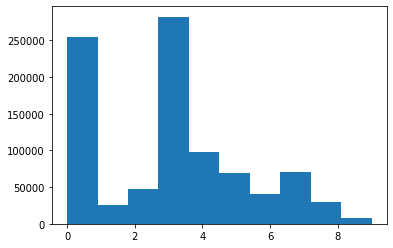

In [14]:
plt.hist(raw_data['digit_4'])
plt.show()

In [15]:
#미리 전처리한 파일이 있을때 쓰는 코드
X_train = pd.read_csv("../input/full-sentence-dataset/preprocessedData.csv", sep=',')
X_train.columns = ['index', 'words']
X_train = X_train['words'].tolist()

X_train_B = pd.read_csv("../input/preprocessed-data/preprocessedData.csv", sep=',')
X_train_B.columns = ['index', 'words']
X_train_B = X_train_B['words'].tolist()

#새로운 전처리
# X_train = preprocessInput(raw_data)
# dataframe = pd.DataFrame(X_train)
# dataframe.to_csv("./preprocessedData.csv")

# PREPARE DATA

In [16]:
train_input = raw_data['sentence']
train_label = raw_data['digit_2']

train_input, val_input, train_label, val_label = \
    train_test_split(np.array(X_train), np.array(raw_data['digit_2'].tolist()), shuffle=True, test_size = 0.1)

In [17]:
#수정
concated_sentence =  X_train_B + X_train
concated_label = raw_data['digit_4'].tolist() + raw_data['digit_4'].tolist()

In [18]:
#수정
train_input_B = raw_data['sentence']
train_label_B = raw_data['digit_4']

train_input_B, val_input_B, train_label_B, val_label_B = \
    train_test_split(np.array(concated_sentence), np.array(concated_label), shuffle=True, test_size = 0.1)

In [19]:
VOCAB_SIZE = VECTOR_SIZE 
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(np.array(X_train))

2022-03-24 16:54:20.122035: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-24 16:54:21.497168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# CHECK VECTORLIZATION

In [20]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)
vocab[:100]

array(['', '[UNK]', '대상', '서비스', '고객', '장', '시설', '사업', '접객', '일반인', '판매',
       '일', '반', '운송', '소비자', '매장', '소매', '요청', '음식점', '제공', '화물',
       '화물자동차', '부동산', '도매', '중개', '개인', '택시', '승객', '받다', '영업', '교육',
       '제조', '사무실', '학원', '용달', '계약', '종교', '의뢰', '학생', '관리', '소매업자',
       '가공', '여', '의류', '커피', '위주', '자동차', '가게', '산업', '수리', '개별', '따르다',
       '소', '공사', '식료품', '염색', '현장', '부품', '미용실', '활동', '환자', '하', '운영',
       '용', '맥주', '미용', '음료', '주점', '파마', '전', '고', '요구', '사용자', '교회',
       '건설', '건물', '외래', '진료', '업체', '음', '업', '한식', '치킨', '기계', '절단',
       '에의', '사', '제작', '여성', '기독교', '용품', '노래방', '두발', '점', '아파트', '없이',
       '편의점', '계통', '가지', '의하다'], dtype='<U8')

In [21]:
print(train_input[:3])
encoded_example = encoder(train_input)[:3].numpy()
encoded_example

['당 구장 게임 시설 당구 게임 서비스' '사업 장 일반인 대상 순대' '영업 장 일반인 대상 한식 제공']


array([[171, 205, 376,   6, 672, 376,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  7,   5,   9,   2, 691,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [ 29,   5,   9,   2,  81,  19,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [22]:
digit_2_code = {v:k for k,v in digit_2_id.items()}
digit_4_code = {v:k for k,v in digit_4_id.items()}

In [23]:
for n in range(3):
    print("Original: ", train_input[n])
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print("label: ",train_label[n])
    print()

Original:  당 구장 게임 시설 당구 게임 서비스
Round-trip:  당 구장 게임 시설 당구 게임 서비스                       
label:  18

Original:  사업 장 일반인 대상 순대
Round-trip:  사업 장 일반인 대상 순대                         
label:  5

Original:  영업 장 일반인 대상 한식 제공
Round-trip:  영업 장 일반인 대상 한식 제공                        
label:  5



# PREPARE MODEL

In [24]:
model_A = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(73, activation='sigmoid')
])

In [25]:
model_A.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
model_B = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64,  activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='sigmoid')
])

In [27]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         332800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [28]:
model_B.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# TRAIN

In [29]:
train_input_data = train_input[:800000]
train_label_data = train_label[:800000]
test_input_data  = train_input[800000:]
test_label_data  = train_label[800000:]

#수정
train_input_data_B = train_input_B[:1600000]
train_label_data_B = train_label_B[:1600000]
test_input_data_B  = train_input_B[1600000:]
test_label_data_B  = train_label_B[1600000:]

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model_A.fit(x = train_input_data,y = train_label_data, 
                    epochs = EPOCH_A,
                    validation_data = (val_input,val_label),
                    steps_per_epoch = STEP,
                    batch_size = BATCH_SIZE,
                    validation_steps = 300,
                    callbacks=[callback]
                   )

Epoch 1/40
700/700 [==============================] - 148s 172ms/step - loss: 2.6127 - accuracy: 0.3778 - val_loss: 1.4468 - val_accuracy: 0.6447
Epoch 2/40
700/700 [==============================] - 105s 151ms/step - loss: 1.1820 - accuracy: 0.7284 - val_loss: 0.9050 - val_accuracy: 0.7900
Epoch 3/40
700/700 [==============================] - 106s 151ms/step - loss: 0.8965 - accuracy: 0.7932 - val_loss: 0.7596 - val_accuracy: 0.8188
Epoch 4/40
700/700 [==============================] - 105s 150ms/step - loss: 0.7833 - accuracy: 0.8147 - val_loss: 0.6768 - val_accuracy: 0.8327
Epoch 5/40
700/700 [==============================] - 104s 149ms/step - loss: 0.7110 - accuracy: 0.8279 - val_loss: 0.6182 - val_accuracy: 0.8440
Epoch 6/40
700/700 [==============================] - 102s 146ms/step - loss: 0.6574 - accuracy: 0.8379 - val_loss: 0.5789 - val_accuracy: 0.8546
Epoch 7/40
700/700 [==============================] - 103s 147ms/step - loss: 0.6184 - accuracy: 0.8469 - val_loss: 0.5435 -

In [31]:
#수정
callback_B = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history_B = model_B.fit(x = train_input_data_B,y = train_label_data_B, 
                    epochs = EPOCH_B,
                    validation_data = (val_input_B,val_label_B),
                    steps_per_epoch = STEP,
                    batch_size = 400,
                    validation_steps = 300,
                    callbacks=[callback_B]
                   )

Epoch 1/50
700/700 [==============================] - 259s 322ms/step - loss: 1.3183 - accuracy: 0.5639 - val_loss: 0.8622 - val_accuracy: 0.7060
Epoch 2/50
700/700 [==============================] - 193s 276ms/step - loss: 0.7739 - accuracy: 0.7440 - val_loss: 0.6662 - val_accuracy: 0.7870
Epoch 3/50
700/700 [==============================] - 195s 278ms/step - loss: 0.6463 - accuracy: 0.7950 - val_loss: 0.5865 - val_accuracy: 0.8135
Epoch 4/50
700/700 [==============================] - 195s 279ms/step - loss: 0.5890 - accuracy: 0.8136 - val_loss: 0.5468 - val_accuracy: 0.8246
Epoch 5/50
700/700 [==============================] - 191s 272ms/step - loss: 0.5544 - accuracy: 0.8239 - val_loss: 0.5201 - val_accuracy: 0.8319
Epoch 6/50
700/700 [==============================] - 190s 272ms/step - loss: 0.5308 - accuracy: 0.8296 - val_loss: 0.5009 - val_accuracy: 0.8380
Epoch 7/50
700/700 [==============================] - 197s 281ms/step - loss: 0.5098 - accuracy: 0.8362 - val_loss: 0.4874 -

# CHECK PERFORMANCE

In [32]:
test_loss, test_acc = model_A.evaluate(val_input,val_label)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2891/2891 [==============================] - 54s 19ms/step - loss: 0.3403 - accuracy: 0.9108
Test Loss: 0.3402869999408722
Test Accuracy: 0.9108009934425354


In [33]:
test_loss_B, test_acc_B = model_B.evaluate(val_input_B,val_label_B)

print('Test Loss:', test_loss_B)
print('Test Accuracy:', test_acc_B)

5782/5782 [==============================] - 105s 18ms/step - loss: 0.3526 - accuracy: 0.8826
Test Loss: 0.35263368487358093
Test Accuracy: 0.8825634121894836


(0.0, 2.7263919696211816)

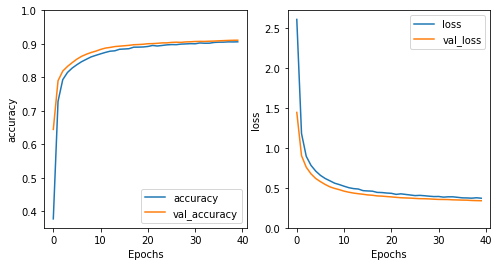

In [34]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

(0.0, 1.366758866608143)

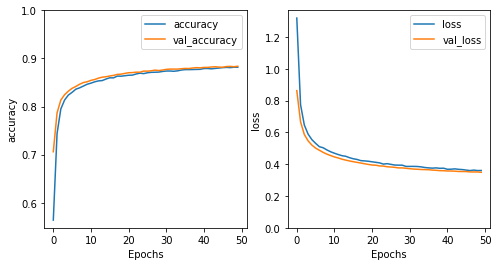

In [35]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_graphs(history_B, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_B, 'loss')
plt.ylim(0, None)

# PREDICTION

In [36]:
submit_input_data = pd.read_csv("../input/full-sentence-dataset/submitInput.csv")

In [37]:
df_submit = submit_input_data.iloc[:,1:2]
df_submit = df_submit.fillna('가')
df_submit.isna().sum()

0    0
dtype: int64

In [38]:
df_submit

,0
0,치킨 전문점 고객 주문 에의 해 치킨 판매
1,산업 공구 다른 소매업자 철물 수 공구
2,절 신다 대상 불교 단체 운영
3,영업 장 고객 요구 자동차튜닝
4,"실내 포장마차 접객 시설 소주 , 맥주 제공"
...,...
99995,사업 장 일반인 대상 버섯 농장
99996,한의원 외래 환자 위주 고 치료
99997,일 반 점포 소비자 그림 판매
99998,사업 장 일반인 . 학생 대상 학습 공간 제공


In [39]:
submision_input = np.array(df_submit)
predictions = model_A.predict(submision_input)
predictions_B = model_B.predict(submision_input)

In [40]:
prediction_to_index = list(map(tf.argmax, predictions))
prediction_to_index_B = list(map(tf.argmax, predictions_B))

In [41]:
prediction_to_index_list = list(map(int,prediction_to_index))
prediction_to_code = list(map(digit_2_code.get, prediction_to_index_list))
print(prediction_to_code[:5])

prediction_to_index_list_B = list(map(int,prediction_to_index_B))
prediction_to_code_B = list(map(digit_4_code.get, prediction_to_index_list_B))
print(prediction_to_code_B[:5])

[56, 46, 94, 96, 56]
['1', '6', '9', '1', '2']


In [42]:
table = code_table()
def transfer_to_group(member):
    cliped_member = str(member)
    return table[table['member'] == int(cliped_member)]['group'].iloc[0]

In [43]:
translated_member = list(map(transfer_to_group, prediction_to_code))
print(len(translated_member))

100000


In [44]:
df_0 = pd.DataFrame(translated_member, columns = ['digit_1'])
df_1 = pd.DataFrame(prediction_to_code, columns = ['digit_2'])
dfs = pd.concat([df_0,df_1], axis=1)

In [45]:
df_2 = pd.DataFrame(prediction_to_code_B, columns = ['digit_3'])

In [46]:
dfs['digit_3'] = df_1['digit_2'].astype(str) + df_2['digit_3']
dfs

,digit_1,digit_2,digit_3
0,I,56,561
1,G,46,466
2,S,94,949
3,S,96,961
4,I,56,562
...,...,...,...
99995,G,47,472
99996,Q,86,862
99997,G,47,474
99998,Q,86,862


In [47]:
dfs.to_csv("solution.csv")

# COMPARE BY TEST DATA

In [48]:
def test_result(model, data, id_dic):
    test_predictions = model.predict(data)
    test_prediction_matrix = list(map(tf.argmax, test_predictions))
    predicted_id = list(map(int,test_prediction_matrix))
    test_prediction_to_code = list(map(id_dic.get, predicted_id))

    test_label_data_code = list(map(id_dic.get, test_label_data_B))
    print(test_label_data_code)
    test_df_pred = pd.DataFrame(test_prediction_to_code, columns = ['prediction'])
    test_df_label = pd.DataFrame(test_label_data_code, columns = ['label'])
    test_df_sentence = pd.DataFrame(data, columns = ['sentence'])
    test_dfs = pd.concat([test_df_pred,test_df_label,test_df_sentence], axis=1)
    return test_dfs

In [49]:
test_dfs_B = test_result(model_B, test_input_data_B, digit_4_code)

['1', '4', '0', '2', '6', '1', '2', '4', '1', '2', '1', '5', '2', '2', '3', '2', '2', '2', '2', '3', '7', '1', '1', '2', '6', '3', '2', '4', '4', '2', '2', '1', '2', '1', '4', '4', '2', '5', '4', '2', '3', '1', '2', '2', '2', '5', '2', '1', '2', '7', '1', '1', '1', '1', '8', '3', '4', '1', '9', '3', '1', '3', '1', '9', '2', '2', '1', '1', '4', '3', '4', '9', '1', '1', '3', '3', '2', '3', '2', '1', '2', '1', '1', '7', '6', '2', '4', '2', '5', '3', '5', '4', '2', '9', '4', '6', '2', '2', '1', '1', '6', '3', '1', '2', '4', '1', '4', '1', '2', '1', '2', '1', '2', '1', '0', '2', '2', '7', '4', '1', '9', '8', '2', '1', '4', '5', '1', '9', '1', '7', '2', '8', '2', '8', '1', '1', '1', '5', '2', '3', '2', '1', '2', '2', '3', '9', '2', '6', '8', '1', '2', '1', '4', '7', '2', '3', '2', '5', '4', '4', '2', '2', '7', '3', '1', '2', '8', '9', '1', '8', '8', '2', '4', '1', '1', '1', '1', '9', '2', '3', '3', '1', '1', '7', '4', '1', '2', '2', '1', '2', '3', '3', '1', '1', '3', '2', '8', '2', '2', '2',

In [50]:
test_dfs_B

,prediction,label,sentence
0,1,1,"돈까스 점 접객 시설 돈까스 , 비후까스 , 우동 판매"
1,4,4,상가 일 반 고객 여성 의류
2,0,0,"고장 난 선박 엔진 용접 , 수리"
3,2,2,"접객 시설 갖추다 커피 , 음료 판매"
4,5,6,"일 반 소비자 대상 볼트 , 일반 철물 , 안전 용품"
...,...,...,...
65011,3,3,일반 소비자 휴대폰
65012,1,1,요양원 노인성 질환 앓다 노인 입소 시키다 노인 요 양 복지 시설 운영
65013,1,2,소매 소비자 농 임산물
65014,1,1,접객 시설 갖추다 순대


In [51]:
test_dfs_B.to_csv("check.csv")